In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
#using matplotlib’s ggplot style
plt.style.use('ggplot')
import seaborn as sns
sns.set(color_codes=True)
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition,linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier,Lasso,LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,f1_score,roc_auc_score,precision_recall_curve,roc_curve,auc
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC  
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning

In [24]:
path ='D:/python_notebook/capstone/'

### state level data

In [25]:
total = pd.read_csv(path + 'final_data(industry not added).csv')
extra_data1=pd.read_csv('./extra_feature1.csv')
extra_data2=pd.read_csv('./extra_feature2.csv')
extra_data=pd.merge(extra_data1,extra_data2,on=['year','state'],how='outer')
total=pd.merge(total,extra_data,on=['year','state'],how='left')
#final_state_data=final_state_data.fillna(final_state_data.mean())

In [26]:
new_target=pd.read_csv('./tagert.csv')
new_target=new_target.drop_duplicates()
new_target['expanding']=(new_target.total_expand-new_target.total_contract)>0
multi_target=pd.DataFrame(new_target.groupby(['state','year'])['expanding'].sum()).reset_index()
multi_target['expanding']=(multi_target['expanding']>=2).astype(int)
multi_class_df=pd.merge(total,multi_target,on=['year','state'],how='inner')


In [27]:
#al=new_target.loc[(new_target.state=='Alabama')&(new_target.year==2000),:]
#new_target

### Correlation Matrix with Features

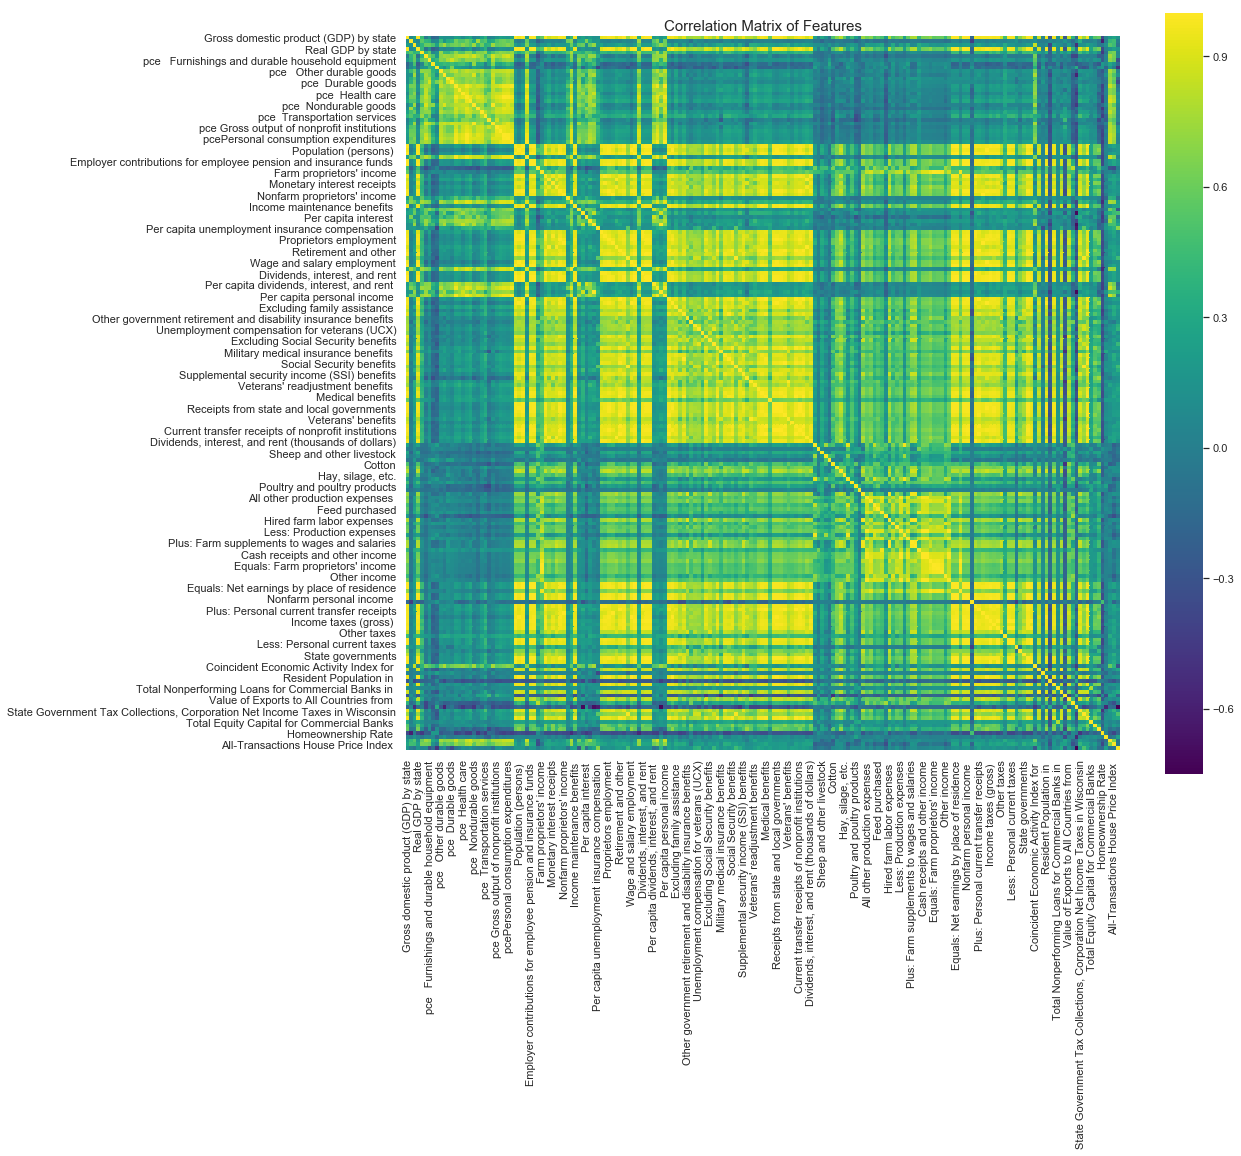

In [28]:
features =total.drop(columns=['contract_establish','expand_establish','end_establish',
                              'net_change','open_establish','total_contract','total_expand',
                              'GeoName','state','year'])

f, ax = plt.subplots(figsize = (16,14))
plt.title('Correlation Matrix of Features', size = 15)
sns.heatmap(features.corr(), square=True, vmax=1, cmap='viridis')

In [29]:
features.shape

(1017, 213)

In [30]:
corr_matrix =features.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [31]:
# Drop features 
final_features =features.drop(columns=to_drop, axis=1)

In [32]:
print(final_features.shape)

(1017, 123)


### Lagged Data Analysis

SME target lagged label -- value changed based on values in this year minus values in previus year

In [33]:
state_list =total.GeoName.unique().tolist()
print(total.shape)
total_2 =total.drop(columns =['contract_establish','expand_establish','end_establish',
                              'net_change','open_establish','total_contract','total_expand'])
#remove DC in year of 2000 row
total_3 =total_2[~((total_2['GeoName'] =='District of Columbia') & (total_2['year'] ==2000))]
print(total_3.shape)
#drop features (corr >0.9)
total_4 =total_3.drop(columns=to_drop, axis=1)
print(total_4.shape)

(1017, 223)
(1016, 216)
(1016, 126)


In [98]:
def clean_state_data(total_4):
    #df_1 =total_3.loc[total_3['GeoName'] == st_name]
    df_1 =total_4.copy()
    df_2 =df_1.set_index(['GeoName','year'])
    df_3_1 =df_2.replace({'(NA)': np.nan ,'(L)':np.nan ,0:np.nan})
    df_3 =df_3_1.drop(columns =['state'])
    #check missing value 
    miss_col = df_3
    miss_col2 = miss_col.isnull().sum(axis =0)/float(len(miss_col))
    miss_col3 =miss_col2.sort_values(ascending=False)
    columns = df_3.columns
    missing_value_df = pd.DataFrame({'percent_missing': miss_col3})
    missing_value_df['percent_missing'] =missing_value_df['percent_missing'].astype('float64')
    
    miss_col =missing_value_df.loc[(missing_value_df['percent_missing'] >0) 
                               &(missing_value_df['percent_missing'] <0.3)].index.tolist()  
    #drop columns with large missing
    del_list = missing_value_df.loc[(missing_value_df['percent_missing'] >=0.3)].index.tolist()
    df_4 = df_3.drop(columns=del_list)
    df_4=df_4.astype(float)
    df_4=df_4.apply(lambda x: x.fillna(x.mean()),axis=0)
    #convert NAN to -99999
    '''
    df_5 = df_4.fillna(-99999)
    #change type of columns
    convert_col =df_5.select_dtypes(include=['object']).columns.values
    for i in convert_col:
        df_5[i] = df_5[i].astype('float')
    df_6 = df_5.copy()
    #replace -99999 to mean()
    for i in miss_col:
        df_6[i] =df_6[i].replace({-99999: df_6[i].mean()})
    '''
    df_7 = df_4.copy()
    #numerical feature scaling
    scaler = MinMaxScaler()
    col =df_7.columns.values
    df_7[col] = scaler.fit_transform(df_7[col]) 
    return df_7

In [99]:
total_5 =clean_state_data(total_4)
print(total_5.shape)

(1016, 116)


In [102]:
total_6 =total_5.reset_index(level='GeoName')
x_train_1 =total_6.loc[[1998,1999,2000,2001,2002,
                        2003,2004,2005,2006,2007,
                        2008,2009,2010,2011,2012]]
x_test_1 =total_6.loc[[2013,2014,2015,2016]]

x_train =x_train_1.drop(columns =['GeoName'])
x_test  =x_test_1.drop(columns =['GeoName'])

District of Columbia records begins on year of 2000,there is no records in DC before year of 2000.

### Target label

In [106]:
# births and death
target_df =total[['year','GeoName','end_establish','open_establish','expand_establish','contract_establish']]
target_col_list =['end_establish','open_establish']
target_df=target_df[~((target_df['GeoName'] =='District of Columbia') & (target_df['year'] ==2000))]
target_df['expanding']=target_df['expand_establish']-target_df['contract_establish']>0
target_df['expanding']=target_df['expanding'].astype(int)
target_df =target_df.set_index(['year'])

1    713
0    303
Name: expanding, dtype: int64

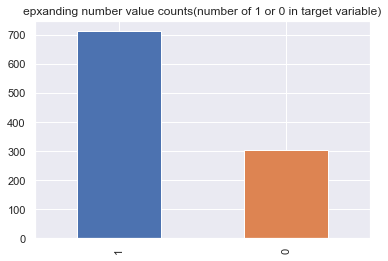

In [107]:
target_df['expanding'].value_counts().plot.bar()
plt.title('epxanding number value counts(number of 1 or 0 in target variable)')
target_df['expanding'].value_counts()

In [108]:
target_df=multi_class_df[['expanding','GeoName','year']]
target_df=target_df[~((target_df['GeoName'] =='District of Columbia') & (target_df['year'] ==2000))]
target_df =target_df.set_index(['year'])

In [109]:
#split train and test data
y_train =target_df.loc[[1998,1999,2000,2001,2002,
                               2003,2004,2005,2006,2007,
                               2008,2009,2010,2011,2012],'expanding']
y_test =target_df.loc[[2013,2014,2015,2016],'expanding']


In [112]:
### SVM

def svm_accuracy(x_train,y_train,x_test,y_test):
    #svm
    clf = SVC(kernel='linear',gamma=50, C=1)
    clf.fit(x_train, y_train)
    y_pred_clf = clf.predict(x_test)
    svm_acc =accuracy_score(y_test, y_pred_clf)
    svm_f1=f1_score(y_test,y_pred_clf)
    return svm_acc,svm_f1

In [113]:
svm_acc_birth =svm_accuracy(x_train, y_train,x_test,y_test)
#svm_acc_death =svm_accuracy(x_train, y_train,x_test,y_test)

In [114]:
print(svm_acc_birth)

(0.946078431372549, 0.9721518987341772)


In [115]:
param_grid = {
                 'max_depth': [5,10,20,30],
                 'max_features':[0.02,0.05,0.1,0.15,0.3], 
                'n_estimators':[10,15,25,30]
             }
rfc = RandomForestClassifier(random_state=42)
grid_clf = GridSearchCV(rfc, param_grid, cv=5,scoring='f1_weighted')
grid_clf.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'max_depth': [5, 10, 20, 30], 'max_features': [0.02, 0.05, 0.1, 0.15, 0.3], 'n_estimators': [10, 15, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [116]:
print(grid_clf.best_score_)

0.8006758083486594


In [117]:
print(grid_clf.best_params_)

{'max_depth': 20, 'max_features': 0.3, 'n_estimators': 30}


In [133]:
# RFC
def rfc_accuracy(x_train,y_train,x_test,y_test):
    #random forest
    rfc = RandomForestClassifier(random_state=42,max_depth=20,max_features=0.3,n_estimators=30)
    rfc.fit(x_train, y_train)
    y_test_pred = rfc.predict(x_test)
    y_train_pred=rfc.predict(x_train)
    rfc_train_acc=accuracy_score(y_train,y_train_pred)
    rfc_test_acc =accuracy_score(y_test, y_test_pred)
    rfc_train_f1=f1_score(y_train,y_train_pred,average='weighted')
    rfc_test_f1=f1_score(y_test,y_test_pred,average='weighted')
    return rfc_train_acc,rfc_test_acc,rfc_train_f1,rfc_test_f1

In [134]:
rtrain_acc,rtest_acc,rtrain_f1,rtest_f1 =rfc_accuracy(x_train, y_train,x_test,y_test)
print((rtrain_acc,rtest_acc))
print((rtrain_f1,rtest_f1))
#rfc_acc_death =rfc_accuracy(x_train, y_train_death,x_test,y_test_death)

(1.0, 0.9362745098039216)
(1.0, 0.9237249887167143)


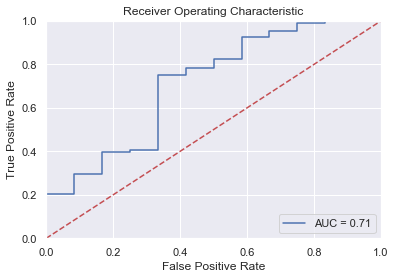

In [120]:
rfc = RandomForestClassifier(random_state=42,max_depth=10,max_features=0.3,n_estimators=30)
rfc.fit(x_train, y_train)
y_test_pred = rfc.predict(x_test)
y_train_pred=rfc.predict(x_train)
probs = rfc.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [146]:
param_grid = {
                'min_child_weight':range(1,8,2),
                'max_depth': [5,10,15],
             }
xgb = XGBClassifier(random_state=42,objective='binary:logistic',learning_rate=0.1,n_estimators=150)
grid_clf = GridSearchCV(xgb, param_grid, cv=5,scoring='f1_weighted')
gcv=grid_clf.fit(x_train, y_train)

In [147]:
grid_clf.best_params_

{'max_depth': 10, 'min_child_weight': 3}

In [149]:
param_grid = {
              'gamma':[0,0.1,0.2,0.4,0.6]
             }
xgb = XGBClassifier(random_state=42,objective='binary:logistic',
                    learning_rate=0.1,
                    max_depth=10,
                    min_child_weight=3
                    ,n_estimators=150)
grid_clf = GridSearchCV(xgb, param_grid, cv=5,scoring='f1_weighted')
gcv=grid_clf.fit(x_train, y_train)
grid_clf.best_params_

In [151]:
param_grid = {
       'subsample':[0.6,0.7,0.8,0.9],
       'colsample_bytree':[0.6,0.7,0.8,0.9]
             }
xgb = XGBClassifier(random_state=42,objective='binary:logistic',
                    learning_rate=0.1,
                    max_depth=10,
                    min_child_weight=3,
                   gamma=0.1)
grid_clf = GridSearchCV(xgb, param_grid, cv=5,scoring='f1_weighted')
gcv=grid_clf.fit(x_train, y_train)

In [152]:
grid_clf.best_params_

{'colsample_bytree': 0.9, 'subsample': 0.8}

In [160]:
# XGB
def xgb_accuracy(x_train,y_train,x_test,y_test):
    #xgb
    xgb =XGBClassifier(objective='binary:logistic',
                       learning_rate=0.1,
                       n_estimators=150,
                      max_depth=10,
                      min_child_weight=3,
                      gamma=0.1,
                      subsample=0.7,
                      colsample_bytree=0.9)
    xgb.fit(x_train, y_train)
    y_pred_xgb = xgb.predict(x_test)
    xgb_acc =accuracy_score(y_test, y_pred_xgb)
    xgb_f1=f1_score(y_test,y_pred_xgb,average='weighted')
    return xgb_acc,xgb_f1

xgb_acc_birth =xgb_accuracy(x_train, y_train,x_test,y_test)
#xgb_acc_death =xgb_accuracy(x_train, y_train_death,x_test,y_test_death)

In [161]:
print(xgb_acc_birth)

(0.946078431372549, 0.9305193833258494)


### Births (Open_Establish) Feature Importance

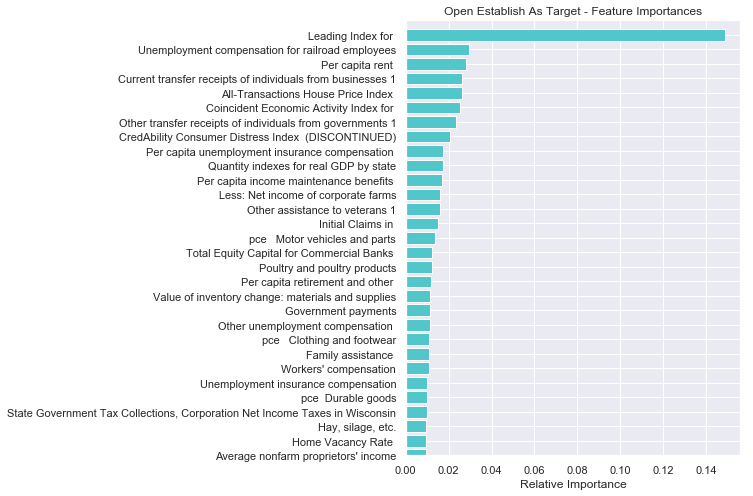

In [124]:
### Feature selection
rfc = RandomForestClassifier(random_state=42)
rfc.fit(x_train, y_train)

feature_importances_rf = pd.DataFrame(rfc.feature_importances_,index = x_train.columns,
                                      columns=['importance']).sort_values('importance', ascending=False)

# feature importance plot
importances_rf = rfc.feature_importances_
indices_rf = np.argsort(importances_rf)

plt.figure(figsize=(6,8))
plt.title('Open Establish As Target - Feature Importances')
plt.xlabel('Relative Importance')

top_n =30
plt.barh(np.arange(top_n), importances_rf[indices_rf[-top_n:]],color='#51C7CB')

plt.yticks(np.arange(top_n), x_train.columns[indices_rf[-top_n:]])
plt.ylim(0, top_n)

plt.show()